# System identification with Neural Networks
## Mohammad Qori Aziz Hakiki - 23222020

Based on Tarek A. Tutunji (2016) - Parametric system identification using neural networks

### 1. Import library

In [1]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from collections import OrderedDict


### 2. Import Dataset From TXT

In [2]:
dataset = np.genfromtxt('6.txt',delimiter=';')
print(dataset)

# Get first column as input, skipping the header
input_tensor=torch.as_tensor(dataset[1:, 0], dtype=torch.float32)
input_tensor = torch.reshape(input_tensor, (len(input_tensor), 1))
# Get second column as output, skipping the header
output_tensor=torch.as_tensor(dataset[1:, 1], dtype=torch.float32)
output_tensor = torch.reshape(output_tensor, (len(output_tensor), 1))
input_tensor = input_tensor / 10
output_tensor = output_tensor / 200
print(input_tensor)
print(output_tensor)

[[      nan       nan       nan       nan]
 [ 5.        0.        0.        5.      ]
 [ 5.        1.06069  16.713107  5.      ]
 ...
 [ 0.        1.161356  0.        0.      ]
 [ 0.        1.010358  0.        0.      ]
 [ 0.        1.010358  0.        0.      ]]
tensor([[0.5000],
        [0.5000],
        [0.5000],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]])
tensor([[0.0000],
        [0.0053],
        [0.0556],
        ...,
        [0.0058],
        [0.0051],
        [0.0051]])


### 3. Define and Apply Time Delay Block to datasets

Here we apply time delay to our data. Suppose we predict that our DC motor transfer function will be like this:

$$H(z) = \frac{Y(z)}{U(z)} = \frac{b_{0} + b_{1}z^{-1}}{1 - a_{1}z^{-1} - a_{2}z^{-2}}$$

In time-domain, 

$$y(k) =a_{1}y(k-1) + a_{2}y(k-2) + b_{0}u(k) + b_{1}u(k-1)$$

Based on the reference paper, we will estimate the $a_{i}$ and $b_{j}$ parameter from the weight of the NN.  

To do so, the neural network inputs will be the delayed target output and inputs, in our case $y(k-1), y(k-2), u(k),$ and $u(k-1)$.


In [3]:
def timedelayblock(input, target, inp_order, target_order):
    delayed_nn_input = input

    # Append delayed input
    for i in range(1, inp_order+1):
        concated_tensor =torch.roll(input, i, 0)
        for j in range(i):
            concated_tensor[j, 0] = 0 # force zeroing delayed input
        delayed_nn_input= torch.cat((delayed_nn_input, concated_tensor), 1)
    
    # Append delayed input
    for k in range(1, target_order+1):
        concated_tensor = torch.roll(target, k, 0)
        for l in range(k):
            concated_tensor[l, 0] = 0 # force zeroing delayed input
        delayed_nn_input= torch.cat((delayed_nn_input, concated_tensor), 1)
    return delayed_nn_input
inp_order = 1
out_order = 2
# Create x(k), x(k-1), y(k-1), and y(k-2)
nn_input= timedelayblock(input_tensor, output_tensor, inp_order, out_order)
print(nn_input[0:5, :])
print(nn_input.size())

tensor([[0.5000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0053, 0.0000],
        [0.5000, 0.5000, 0.0556, 0.0053],
        [0.5000, 0.5000, 0.1188, 0.0556]])
torch.Size([12473, 4])


In [4]:
# Split training and test data
nn_input_train = nn_input[:10000, :]
nn_input_test = nn_input[10000:, :]

y_train =output_tensor[:10000, :]
y_test = output_tensor[10000:, :]

### 4. Define NN Class

Define the NN model that will be used.  
Here we will add hidden layer and act function based on the parameters provided.

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_features, hidden_dim, hidden_layer, out_classes):
        super(NeuralNetwork, self).__init__()
        # Create ordered Dictionary based on the number of hidden_layer
        sequence = OrderedDict()
        for layer in range(hidden_layer):
            if layer == 0:
                sequence['hidden_layer_{}'.format(layer)] =nn.Linear(
                    in_features, hidden_dim, bias=False)
                sequence['activation_{}'.format(layer)] =  nn.Tanh()
                continue
            # For layer not in the input layer
            sequence['hidden_layer_{}'.format(layer)] = nn.Linear(
                hidden_dim, hidden_dim, bias=False)
            sequence['activation_{}'.format(layer)] = nn.Tanh()
        # Insert output layer
        sequence['output_layer'] = nn.Linear(hidden_dim, out_classes, bias=False)

        # print(sequence)
        # return the sequential model
        self.layer_stack = nn.Sequential(sequence)
        

    def forward(self, x):
        x = self.layer_stack(x)
        return x


In [6]:
# Variable declaration
# Since we have u(k), u(k-1), y(k-1), and y(k-2), we have 4 inputs.

in_features=inp_order + out_order +1  # how many Variables are in the dataset
hidden_dim= inp_order + out_order +1 # hidden i/o
hidden_layer=3 # how many hidden layers
output_dim=1   # number of classes
epoch = 100

In [7]:
clf=NeuralNetwork(in_features,hidden_dim, hidden_layer, output_dim)
print(clf)

params = clf.parameters()
# print(len(params))

for p in params:
    print(p.size())  # conv1's .weight
    print(p)

NeuralNetwork(
  (layer_stack): Sequential(
    (hidden_layer_0): Linear(in_features=4, out_features=4, bias=False)
    (activation_0): Tanh()
    (hidden_layer_1): Linear(in_features=4, out_features=4, bias=False)
    (activation_1): Tanh()
    (hidden_layer_2): Linear(in_features=4, out_features=4, bias=False)
    (activation_2): Tanh()
    (output_layer): Linear(in_features=4, out_features=1, bias=False)
  )
)
torch.Size([4, 4])
Parameter containing:
tensor([[ 0.4587,  0.3150, -0.3044,  0.4501],
        [ 0.2548,  0.4376,  0.4382, -0.1791],
        [ 0.0274, -0.3218, -0.4943, -0.2234],
        [-0.4064,  0.3847,  0.0688, -0.3298]], requires_grad=True)
torch.Size([4, 4])
Parameter containing:
tensor([[-0.2490,  0.4282, -0.0078,  0.0721],
        [ 0.2360,  0.4942,  0.3090,  0.1506],
        [ 0.1499, -0.3351,  0.3966,  0.3416],
        [-0.1376, -0.0485, -0.2908,  0.4393]], requires_grad=True)
torch.Size([4, 4])
Parameter containing:
tensor([[ 0.3169,  0.0982, -0.4441,  0.0842],
    

### 5. Compute weight and biases of our networks

In [8]:
# Test our networks
out = clf(nn_input_train)
print(out)

tensor([[0.0081],
        [0.0056],
        [0.0057],
        ...,
        [0.0106],
        [0.0105],
        [0.0106]], grad_fn=<MmBackward0>)


In [9]:
# Construct loss function for learning
criterion = nn.MSELoss()
# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(clf.parameters(), lr = 0.3)

In [10]:
for e in range(epoch):
   # Forward pass: Compute predicted y by passing x to the model
   y_pred = clf(nn_input_train)

   # Compute and print loss
   loss = criterion(y_pred, y_train)
   print('epoch: ', e,' loss: ', loss.item())

   # Zero gradients, perform a backward pass, and update the weights.
   optimizer.zero_grad()

   # perform a backward pass (backpropagation)
   loss.backward()

   # Update the parameters
   optimizer.step()

epoch:  0  loss:  0.343443363904953
epoch:  1  loss:  0.10957738012075424
epoch:  2  loss:  0.2395877242088318
epoch:  3  loss:  0.11248930543661118
epoch:  4  loss:  0.10091258585453033
epoch:  5  loss:  0.0751999169588089
epoch:  6  loss:  0.06118910387158394
epoch:  7  loss:  0.023123841732740402
epoch:  8  loss:  0.6562198996543884
epoch:  9  loss:  0.03727765753865242
epoch:  10  loss:  0.09289498627185822
epoch:  11  loss:  0.0787704810500145
epoch:  12  loss:  0.12578193843364716
epoch:  13  loss:  0.06740116328001022
epoch:  14  loss:  0.09606015682220459
epoch:  15  loss:  0.09387806057929993
epoch:  16  loss:  0.06448802351951599
epoch:  17  loss:  0.09287644922733307
epoch:  18  loss:  0.08471325784921646
epoch:  19  loss:  0.0647684633731842
epoch:  20  loss:  0.08490799367427826
epoch:  21  loss:  0.079119972884655
epoch:  22  loss:  0.06460532546043396
epoch:  23  loss:  0.0794159471988678
epoch:  24  loss:  0.07540199905633926
epoch:  25  loss:  0.06460954248905182
epoch

In [11]:
for param in clf.parameters():
   print(param)

# Loss testing
y_pred_test = clf(nn_input_test)
print(y_pred_test)
loss = criterion(y_pred_test, y_test)
print(' loss: ', loss.item())

Parameter containing:
tensor([[-1.3750, -1.5168, -2.2057, -1.4500],
        [ 1.4519,  1.6401,  1.8906,  1.2727],
        [-1.5990, -1.9546, -2.3034, -2.0325],
        [-1.9199, -1.1321, -1.6261, -2.0250]], requires_grad=True)
Parameter containing:
tensor([[-0.4293,  1.7380, -1.3663, -1.3415],
        [ 0.5600, -1.0439,  1.8066,  1.3852],
        [-0.0114, -2.5017,  2.5765,  2.2898],
        [-2.7254,  1.1268, -1.2523, -1.0416]], requires_grad=True)
Parameter containing:
tensor([[-0.1003, -1.0371, -2.8860,  0.5279],
        [ 0.0128, -2.1046,  0.7364,  1.8228],
        [ 0.4460, -1.0124,  0.7605, -0.7749],
        [-0.1888,  3.2053,  1.6482, -0.7486]], requires_grad=True)
Parameter containing:
tensor([[-6.6599e-02,  6.2099e-01,  1.2042e-02, -2.0128e-04]],
       requires_grad=True)
tensor([[0.5516],
        [0.5516],
        [0.5516],
        ...,
        [0.1788],
        [0.1695],
        [0.1578]], grad_fn=<MmBackward0>)
 loss:  0.024422576650977135


tensor([[0.5516],
        [0.5516],
        [0.5516],
        ...,
        [0.1788],
        [0.1695],
        [0.1578]], grad_fn=<MmBackward0>)


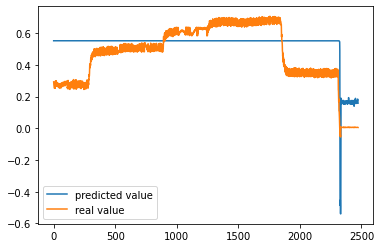

In [12]:
import matplotlib.pyplot as plt
nn_input_test = nn_input_test.detach().numpy()

y_pred_test_detach = y_pred_test.detach().numpy()

y_test = y_test.detach().numpy()
# plt.plot(nn_input_test, label='input value')
plt.plot(y_pred_test_detach, label='predicted value')
plt.plot(y_test, label='real value')
leg = plt.legend()

print(y_pred_test)

In [13]:
# Check weight
params = clf.named_parameters()

for p in params:
    print(p)

('layer_stack.hidden_layer_0.weight', Parameter containing:
tensor([[-1.3750, -1.5168, -2.2057, -1.4500],
        [ 1.4519,  1.6401,  1.8906,  1.2727],
        [-1.5990, -1.9546, -2.3034, -2.0325],
        [-1.9199, -1.1321, -1.6261, -2.0250]], requires_grad=True))
('layer_stack.hidden_layer_1.weight', Parameter containing:
tensor([[-0.4293,  1.7380, -1.3663, -1.3415],
        [ 0.5600, -1.0439,  1.8066,  1.3852],
        [-0.0114, -2.5017,  2.5765,  2.2898],
        [-2.7254,  1.1268, -1.2523, -1.0416]], requires_grad=True))
('layer_stack.hidden_layer_2.weight', Parameter containing:
tensor([[-0.1003, -1.0371, -2.8860,  0.5279],
        [ 0.0128, -2.1046,  0.7364,  1.8228],
        [ 0.4460, -1.0124,  0.7605, -0.7749],
        [-0.1888,  3.2053,  1.6482, -0.7486]], requires_grad=True))
('layer_stack.output_layer.weight', Parameter containing:
tensor([[-6.6599e-02,  6.2099e-01,  1.2042e-02, -2.0128e-04]],
       requires_grad=True))


### 6. Transform NN Weights to Transfer Function

In here, we define an NN2TF algorithm. Based on the reference paper, the parameter $a_{j}$ and $b_{i}$ can be estimated by

$$a_{j} = (\sum_{h=1}^H (wout_{h}v_{jh}))$$

$$b_{i} = (\sum_{h=1}^H (wout_{h}w_{ih}))$$

For tanh activation function.

In [14]:
def nn2tf(nn, hidden_layer, inp_order, target_order):
    regressor = np.zeros((1, inp_order+target_order+1))
    wout = nn.state_dict()['layer_stack.output_layer.weight']
    wout = wout.numpy()
    print('wout : ', wout)
    # print(wout.size())
    params = nn.named_parameters()
    i = 0
    for p in params:
        # print(p)

        w_hidden = nn.state_dict()['layer_stack.hidden_layer_{}.weight'.format(i)]
        w_hidden = w_hidden.numpy()
        print('w_hidden : ', w_hidden)
        # Update regressor
        regressor = regressor + (wout @ w_hidden)
        print(regressor)

        i = i + 1
        if i == hidden_layer :
            break
    
    # regressor = regressor * 0.5
    return regressor


regressor = nn2tf(clf, hidden_layer, inp_order, out_order)
print(regressor)

wout :  [[-6.6598929e-02  6.2099141e-01  1.2041538e-02 -2.0128273e-04]]
w_hidden :  [[-1.3749508 -1.5168347 -2.205702  -1.4499735]
 [ 1.4519336  1.6401224  1.8905712  1.2727253]
 [-1.59897   -1.9545888 -2.3033864 -2.0325174]
 [-1.9198805 -1.1321119 -1.6261399 -2.0250142]]
[[0.97434092 1.0962131  1.29351699 0.86285114]]
w_hidden :  [[-0.4293141   1.7380456  -1.366337   -1.3415337 ]
 [ 0.5600272  -1.0439171   1.8066499   1.3852137 ]
 [-0.01139524 -2.5017188   2.5764654   2.2898226 ]
 [-2.725442    1.1267585  -1.2523189  -1.0416069 ]]
[[1.35111618 0.30184627 2.53770435 1.84018427]]
w_hidden :  [[-0.10031815 -1.0371323  -2.8860183   0.52790207]
 [ 0.01282981 -2.104636    0.7364032   1.822812  ]
 [ 0.44600984 -1.012363    0.7604875  -0.7749417 ]
 [-0.18883322  3.205305    1.6481677  -0.74860007]]
[[ 1.37117312 -0.94887817  3.1960358   2.92779642]]
[[ 1.37117312 -0.94887817  3.1960358   2.92779642]]


In [15]:
# Stabilize pole, use if there are unstable pole

# for i in range(inp_order + 1, len(regressor[0])):
#     print(i)
#     while abs(regressor[0][i]) > 1:
#         regressor[0][i]= regressor[0][i] * 0.9
#         # print(regressor[0][i])
#         print(regressor)


In [16]:
# # Calculate estimated output from our model
y_pred = np.zeros((len(output_tensor),1))

nn_input_detach = nn_input.detach().numpy()

# for i in range(len(output_tensor)):
#     for j in range (len(regressor)):
#         y_pred[i] += regressor[0][j] * nn_input_detach[i][j]
   

In [17]:
# # Plot estimated output

# print(y_pred)
# plt.plot(y_pred, label='estimated value')
# plt.plot(output_tensor, label='real value')
# leg = plt.legend()


In [18]:
 # Calculate estimated output from our model
for i in range(len(output_tensor)):
    if i == 0 :
        y_pred[i] = regressor[0][0] * nn_input_detach[i][0]
        continue
    
    # Fill y(k-1)
    if i >= 1 :
        nn_input_detach[i][2] = y_pred[i-1]
    
        # Fill y(k-2)
    if i >=2 :
        nn_input_detach[i][3] = y_pred[i-2]

    for j in range (len(regressor)):
        y_pred[i] += regressor[0][j] * nn_input_detach[i][j]

[[0.68558656]
 [0.68558656]
 [0.68558656]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


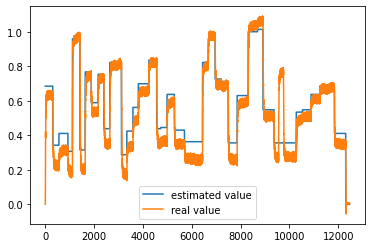

In [19]:
# Plot estimated output

print(y_pred)
plt.plot(y_pred, label='estimated value')
plt.plot(output_tensor, label='real value')
leg = plt.legend()